In [2]:
from pymongo import MongoClient
from keras.preprocessing.text import Tokenizer
from sklearn import preprocessing

client = MongoClient("localhost", 27017, maxPoolSize=50)
db = client.sc
collection = db['messages']
cursor = collection.find({})
data = []
labels = []

for document in cursor:        
        data.append(document['text'])
        labels.append(document['user'])

tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
one_hot_results = tokenizer.texts_to_matrix(data, mode='binary')


data = []
lb = preprocessing.LabelBinarizer()
labels = lb.fit_transform(labels)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 553 unique tokens.


### Visualization of words we use a lot

In [19]:
import numpy as np

data = one_hot_results
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

training_samples = 517104
validation_samples = 172367
max_words = 10000

x_train = data[:training_samples]
y_train = labels[:training_samples]

x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

x_test = data[training_samples + validation_samples: training_samples + 2 * validation_samples]
y_test = labels[training_samples + validation_samples: training_samples + training_samples + 2 * validation_samples]

In [20]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

embedding_dim = 64

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=one_hot_results.shape[1]))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(19, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 1000, 64)          640000    
_________________________________________________________________
flatten_3 (Flatten)          (None, 64000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2048032   
_________________________________________________________________
dense_6 (Dense)              (None, 19)                627       
Total params: 2,688,659
Trainable params: 2,688,659
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,epochs=2,batch_size=32, validation_data=(x_val, y_val))
model.save_weights('pre_trained.h5')

Train on 517104 samples, validate on 172367 samples
Epoch 1/2
517104/517104 [==============================] - 385s 745us/step - loss: 0.1852 - acc: 0.9474 - val_loss: 0.1850 - val_acc: 0.9474
Epoch 2/2
517104/517104 [==============================] - 402s 777us/step - loss: 0.1851 - acc: 0.9474 - val_loss: 0.1851 - val_acc: 0.9474


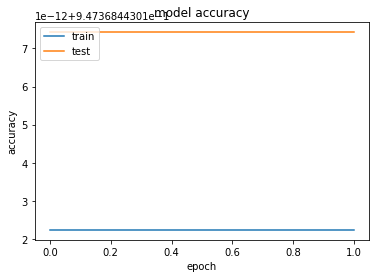

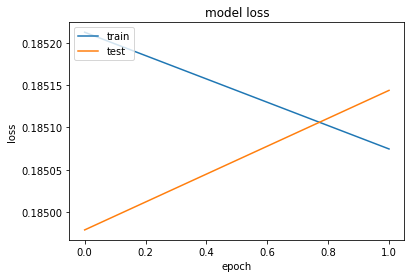

In [23]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Learn with an embedding layer

In [58]:
data = pad_sequences(one_hot_results, maxlen=maxlen)
#labels = np.asarray(labels)

print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

training_samples = 200
validation_samples = 1000
max_words = 10000

x_train = data[:training_samples]
y_train = labels[:training_samples]

x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

x_test = data[training_samples + validation_samples: training_samples + 2 * validation_samples]
y_test = labels[training_samples + validation_samples: training_samples + 2 * validation_samples]

Shape of data tensor: (861840, 100)
Shape of label tensor: (861840, 19)


In [59]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

embedding_dim = 128

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(19, activation='sigmoid'))

model.summary()

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 128)          1280000   
_________________________________________________________________
flatten_11 (Flatten)         (None, 12800)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                409632    
_________________________________________________________________
dense_22 (Dense)             (None, 19)                627       
Total params: 1,690,259
Trainable params: 1,690,259
Non-trainable params: 0
_________________________________________________________________
Train on 200 samples, validate on 1000 samples
Epoch 1/10
200/200 [==============================] - 1s 3ms/step - loss: 0.5587 - acc: 0.7374 - val_loss: 0.4459 - val_acc: 0.7649
Epoch 2/10
200/200 [==============================] - 0s 491us/step - loss: 0.4076 - 

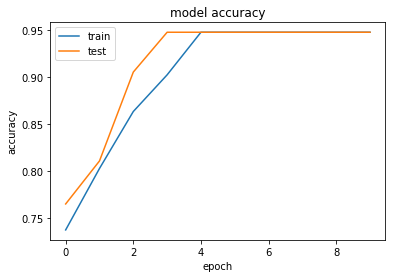

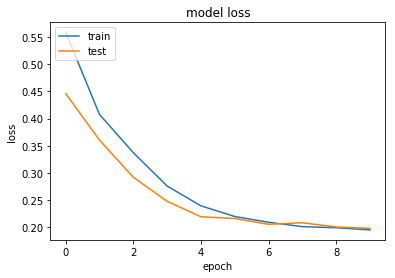

In [60]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [62]:
accuracy = model.evaluate(x_test, y_test)

1000/1000 [==============================] - 0s 45us/step


In [68]:
y_pred = model.predict(x_train)

In [75]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_pred)

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [90]:
a = np.where( y_train == 1 )

In [88]:
a[1]

array([ 4,  2,  7,  2, 14,  7,  7,  7,  1,  2,  5, 15,  4, 12, 15,  1,  5,
        1, 12,  7,  6,  4, 16,  8, 11,  1,  5,  2,  2, 12,  4,  4,  9,  9,
        4, 12, 17,  2,  2,  5,  3, 15, 18,  2,  5,  4, 18,  1,  2,  2,  2,
        4,  7, 11, 14,  4, 18, 16, 17, 18, 16,  4,  2,  9, 18,  4,  3,  4,
       12,  5, 11,  1,  2,  5,  9,  4,  7,  2,  4,  2, 12,  5,  2,  4, 10,
        3,  4,  2,  3,  5,  4,  5,  2,  4,  9, 12, 12,  3,  4, 12,  7, 14,
        2,  7,  4,  6,  4, 14,  2, 11,  6,  3, 12,  2, 12,  4, 14, 18,  3,
        7,  7,  4, 10,  9, 18,  5,  2,  4, 14,  4,  0,  9,  2,  0,  6,  2,
       18, 18,  4,  3,  4,  8, 14,  4,  6,  5,  2,  3,  3,  5, 12,  4, 15,
        4,  1,  2,  5,  4,  3,  9,  2,  4, 14, 12, 14,  9,  4,  9,  5,  5,
       18,  9, 13,  4,  5,  7,  9,  5,  9, 16, 10, 12,  7,  4, 10,  3,  7,
        2,  7,  9,  2, 15,  4,  4,  4,  7,  1,  3,  1,  4])

In [89]:
y_train[0]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])